# GAN 실습

## - Generative Adversarial Networks


In [7]:
import torch
#신경망을 만들기 위해 torch.nn을 불러옴
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
#torchvision은 유명한 데이터셋들, 이미 구현되어져 있는 유명한 모델들, 일반적인 이미지 전처리 도구들을 포함하고 있는 패키지이다.
from torchvision.transforms.functional import to_pil_image
import matplotlib.pylab as plt
%matplotlib inline

import os
import numpy as np
import time

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## 데이터 불러오기

#### - Mnist데이터 다운로드 (in TensorFlow 샘플)
#### (간단한 컴퓨터 비전 데이터 세트로, 손글씨 이미지들로 구성되어 있다)

In [4]:
train_data = dsets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
test_data  = dsets.MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)

print('number of training data: ', len(train_data))
print('number of test data: ', len(test_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

number of training data:  60000
number of test data:  10000


In [9]:
path2data = './data'
os.makedirs(path2data, exist_ok=True)

In [10]:
#Data 불러오기
train_ds = datasets.MNIST(path2data, train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.5],[0.5])]), download=True)

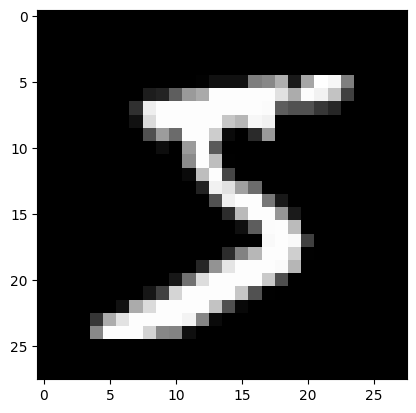

In [11]:
#Data 확인
img, label = train_ds[0]
plt.imshow(to_pil_image(0.5*img+0.5),cmap='gray')

In [12]:
#DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [13]:
for x, y in train_dl:
    print(x.shape, y.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


# 모델 구축

## Idea - 생성기 G 와 분별기 D 의 '대립 구도' 를 이용한다.
## Purpose - G가 만들어내는 샘플을 D가 구별하지 못하는 수준까지 학습시키는 것이다.
![GAN 원리](https://ifh.cc/g/plo5nV.jpg)

- Generator(생성자) : 임의로 생성된 Noise 를 입력받아 영상(이미지)를 생성한다.

- 비지도 학습으로 정의된다.

In [28]:
class Generator(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.nz = params['nz'] 
        self.img_size = params['img_size'] # 이미지 크기, 1x28x28

        self.model = nn.Sequential(
            *self._fc_layer(self.nz, 128, normalize=False),
            *self._fc_layer(128,256),
            *self._fc_layer(256,512),
            *self._fc_layer(512,1024),
            nn.Linear(1024,int(np.prod(self.img_size))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_size)
        return img

    
    def _fc_layer(self, in_channels, out_channels, normalize=True):
        layers = []
        layers.append(nn.Linear(in_channels, out_channels)) 
        if normalize:
            layers.append(nn.BatchNorm1d(out_channels, 0.8)) 
        layers.append(nn.LeakyReLU(0.2)) 
        return layers
params = {'nz':100,
          'img_size':(1,28,28)}
x = torch.randn(16,100).to(device) # 난수생성
model_gen = Generator(params).to(device)
output = model_gen(x) # noise를 입력받아 이미지 생성
print(output.shape)

torch.Size([16, 1, 28, 28])


- Discriminator(구별자) : real data 에서 추출한 데이터와 generator 에서 생성한 데이터를 비교하여 무엇이 real data인지 구별함.
</br>
- 생성자의 역순으로 설계

In [29]:
class Discriminator(nn.Module):
    def __init__(self,params):
        super().__init__()
        self.img_size = params['img_size'] # 이미지 크기, 1x28x28

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(self.img_size)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0),-1)
        x = self.model(x)
        return x

x = torch.randn(16,1,28,28).to(device)
model_dis = Discriminator(params).to(device)
output = model_dis(x)
print(output.shape)

torch.Size([16, 1])


## 학습 준비

In [31]:
#가중치 초기화
#과잉적합, 과소적합등의 문제를 해결할 수 있음.
def initialize_weights(model):
    classname = model.__class__.__name__
    
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

## 학습

In [27]:
loss_func = nn.BCELoss()
#손실 함수

In [39]:
from torch import optim

# 최적화 파라미터
lr = 2e-4
beta1 = 0.5

opt_dis = optim.Adam(model_dis.parameters(),lr=lr,betas=(beta1,0.999))
opt_gen = optim.Adam(model_gen.parameters(),lr=lr,betas=(beta1,0.999))

In [40]:
real_label = 1.
fake_label = 0.
nz = params['nz']
num_epochs = 10
#epoch의 수가 많을때, 시간이 많이 걸렸으므로 10번으로 제한했다.

loss_history={'gen':[],
              'dis':[]}

In [41]:
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
    for xb, yb in train_dl:
        ba_si = xb.size(0)

        xb = xb.to(device)
        yb_real = torch.Tensor(ba_si,1).fill_(1.0).to(device)
        yb_fake = torch.Tensor(ba_si,1).fill_(0.0).to(device)

        # Generator
        model_gen.zero_grad()
        noise = torch.randn(ba_si,nz, device=device) # 노이즈 생성
        out_gen = model_gen(noise) # 가짜 이미지 생성
        out_dis = model_dis(out_gen) # 가짜 이미지 판별

        loss_gen = loss_func(out_dis, yb_real)
        loss_gen.backward()
        opt_gen.step()

        # Discriminator
        model_dis.zero_grad()

        out_real = model_dis(xb) # 진짜 이미지 판별
        out_fake = model_dis(out_gen.detach()) # 가짜 이미지 판별
        loss_real = loss_func(out_real, yb_real)
        loss_fake = loss_func(out_fake, yb_fake)
        loss_dis = (loss_real + loss_fake) / 2

        loss_dis.backward()
        opt_dis.step()

        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())

        batch_count += 1
        if batch_count % 1000 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))
     

Epoch: 0, G_Loss: 2.642829, D_Loss: 0.233257, time: 0.33 min
Epoch: 1, G_Loss: 3.013965, D_Loss: 0.269601, time: 0.69 min
Epoch: 1, G_Loss: 2.086743, D_Loss: 0.282786, time: 1.03 min
Epoch: 2, G_Loss: 1.592244, D_Loss: 0.236441, time: 1.37 min
Epoch: 2, G_Loss: 3.138910, D_Loss: 0.141815, time: 1.71 min
Epoch: 3, G_Loss: 2.908323, D_Loss: 0.277627, time: 2.05 min
Epoch: 3, G_Loss: 2.900394, D_Loss: 0.231209, time: 2.39 min
Epoch: 4, G_Loss: 2.898343, D_Loss: 0.190540, time: 2.72 min
Epoch: 4, G_Loss: 2.917703, D_Loss: 0.194003, time: 3.06 min
Epoch: 5, G_Loss: 2.209613, D_Loss: 0.113732, time: 3.39 min
Epoch: 5, G_Loss: 2.130441, D_Loss: 0.236323, time: 3.73 min
Epoch: 6, G_Loss: 2.059901, D_Loss: 0.229477, time: 4.07 min
Epoch: 6, G_Loss: 2.250059, D_Loss: 0.284138, time: 4.40 min
Epoch: 7, G_Loss: 3.930276, D_Loss: 0.306808, time: 4.74 min
Epoch: 7, G_Loss: 2.761353, D_Loss: 0.266794, time: 5.08 min
Epoch: 8, G_Loss: 3.566232, D_Loss: 0.360119, time: 5.41 min
Epoch: 9, G_Loss: 1.9517

+) 10번의 학습을 진행하는데 6분이 소요됨을 알 수 있다.

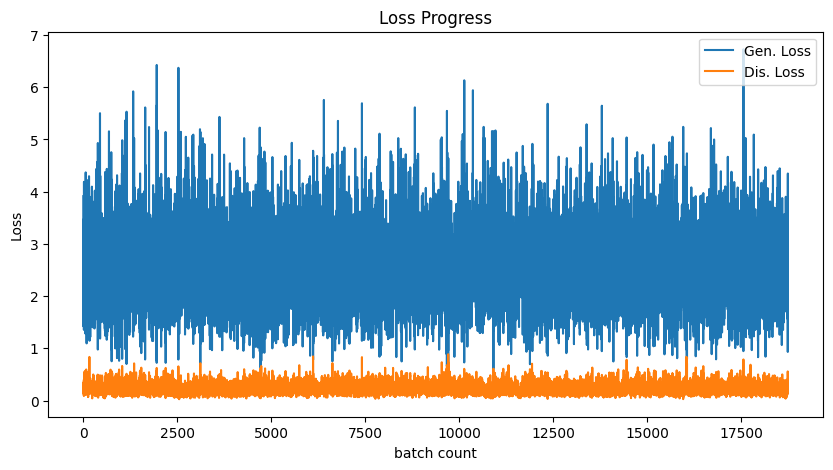

In [42]:
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()
#손실함수 그래프로 표현    

In [43]:
#가중치 저장
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

## 이미지 확인
### Generator에서 생성한 가짜 이미지를 확인한다.

In [44]:
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evaluation mode
model_gen.eval()

# 가짜 이미지 생성
with torch.no_grad():
    fixed_noise = torch.randn(16, 100, device=device)
    img_fake = model_gen(fixed_noise).detach().cpu()
print(img_fake.shape)

torch.Size([16, 1, 28, 28])


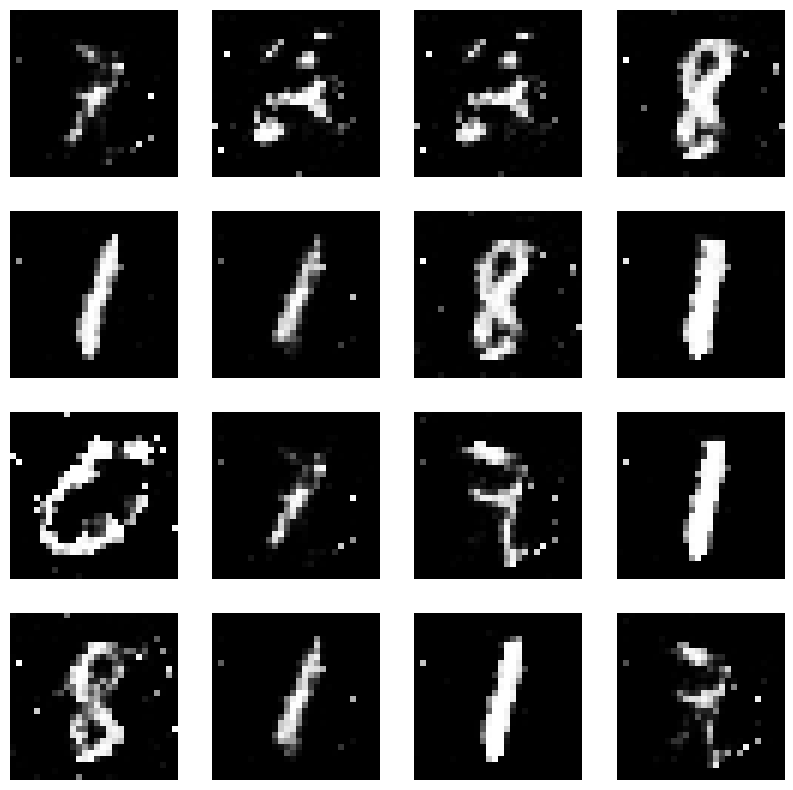

In [45]:
plt.figure(figsize=(10,10))
for ii in range(16):
    plt.subplot(4,4,ii+1)
    plt.imshow(to_pil_image(0.5*img_fake[ii]+0.5),cmap='gray')
    plt.axis('off')

## 결론

#### [Goodfellow2014](https://arxiv.org/pdf/1406.2661.pdf) 에서의 GAN을 구현할 수 있다.
![GAN DMLP](https://ifh.cc/g/OK6d3D.jpg)